# Assignment 7: Brandi Beals
## MSDS 422 DL-55

This week, you will compete in the Dogs vs. Cats kernels Edition Kaggle.com competition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition. Specifically, you will build models using the training set to forecast the test set. The images are in .jpg format, so you will need to research how to handle that. You are required to submit no fewer than four models for evaluation by Kaggle.com, and you must provide your Kaggle.com scores and user ID for validation. 

We will employ at least a 2x2 completely crossed experimental design. We will again use a simple training-and-test regimen. The factors in the design may include numbers of layers and/or nodes within layers, types of layers (convolutional or pooling), and/or other hyperparameters. You will utilize convolutional neural networks (CNNs) within Python TensorFlow. 

In [1]:
import cv2
import numpy as np
import os         
from random import shuffle 
from tqdm import tqdm      
import tensorflow as tf
import matplotlib.pyplot as plt
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
%matplotlib inline
TRAIN_DIR = 'dogs-vs-cats-redux-kernels-edition/train/train'
TEST_DIR = 'dogs-vs-cats-redux-kernels-edition/test/test'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'dogs-vs-cats-convnet'

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Colocations handled automatically by placer.


In [2]:
def create_label(image_name):
    """ Create an one-hot encoded vector from image name """
    word_label = image_name.split('.')[-3]
    if word_label == 'cat':
        return np.array([1,0])
    elif word_label == 'dog':
        return np.array([0,1])

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img_data), create_label(img)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img_data), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [4]:
# If dataset is not created:
train_data = create_train_data()
test_data = create_test_data()
# If you have already created the dataset:
# train_data = np.load('train_data.npy')
# test_data = np.load('test_data.npy')
train = train_data[:-500]
test = train_data[-500:]
X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = [i[1] for i in train]
X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = [i[1] for i in test]

100%|██████████| 12500/12500 [01:19<00:00, 158.08it/s]


### Baseline Model

In [5]:
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 12.22447 | time: 72.336s
| Adam | epoch: 010 | loss: 12.22447 - acc: 0.4691 -- iter: 24448/24500
Training Step: 3830  | total loss: 12.26125 | time: 73.529s
| Adam | epoch: 010 | loss: 12.26125 - acc: 0.4675 | val_loss: 11.51293 - val_acc: 0.5000 -- iter: 24500/24500
--


cat: 1.0, dog: 0.0


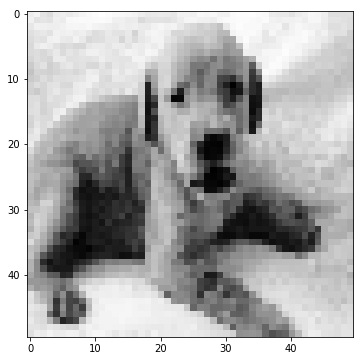

In [6]:
d = test_data[0]
img_data, img_num = d

data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
prediction = model.predict([data])[0]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap="gray")
print(f"cat: {prediction[0]}, dog: {prediction[1]}")

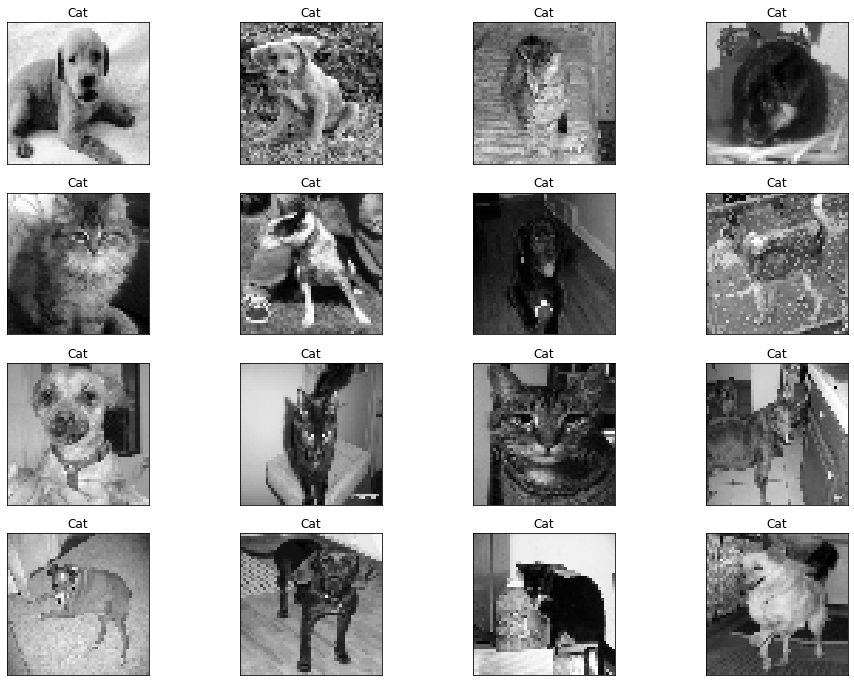

In [7]:
fig=plt.figure(figsize=(16, 12))

for num, data in enumerate(test_data[:16]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

### Model 1

In [8]:
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.34257 | time: 76.869s
| Adam | epoch: 010 | loss: 0.34257 - acc: 0.8491 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.33783 | time: 78.113s
| Adam | epoch: 010 | loss: 0.33783 - acc: 0.8502 | val_loss: 0.49841 - val_acc: 0.7880 -- iter: 24500/24500
--


cat: 0.9680044054985046, dog: 0.031995564699172974


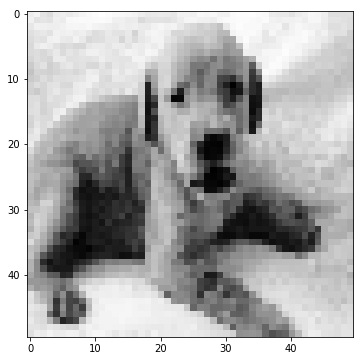

In [9]:
d = test_data[0]
img_data, img_num = d

data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
prediction = model.predict([data])[0]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap="gray")
print(f"cat: {prediction[0]}, dog: {prediction[1]}")

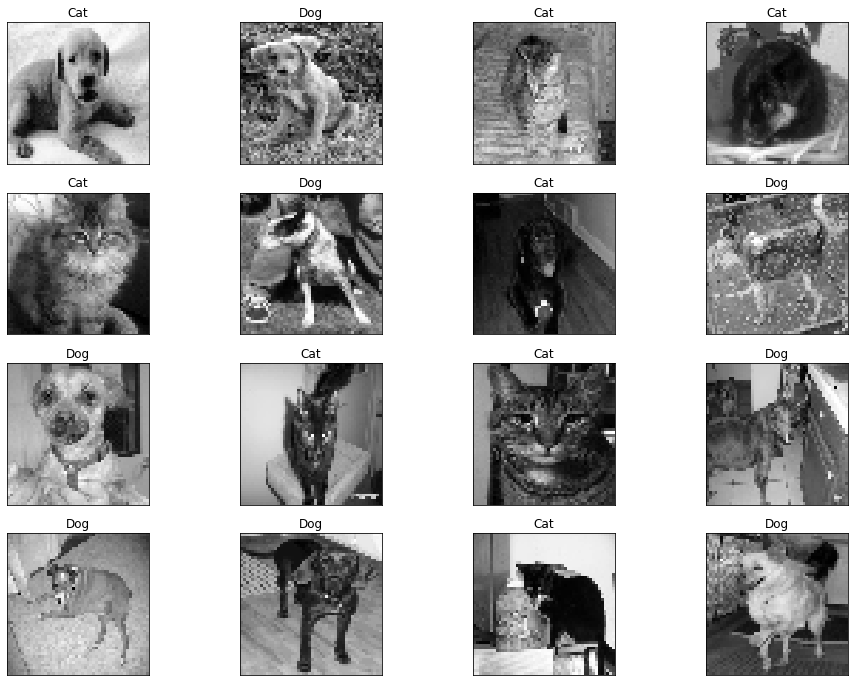

In [10]:
fig=plt.figure(figsize=(16, 12))

for num, data in enumerate(test_data[:16]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [19]:
test_data[10][1]

'3390'

In [20]:
import pandas as pd

In [34]:
df = pd.DataFrame({'id': [], 'label': []})

for num, data in enumerate(test_data):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
    
    df = df.append({'id': img_num, 'label': np.argmax(model_out)}, ignore_index=True)

In [32]:
df

,id,label
0,9768,0.0
1,7450,1.0
2,8026,0.0
3,11605,0.0
4,6924,0.0
5,10110,1.0
6,6305,0.0
7,727,1.0
8,4606,1.0
9,6557,0.0


In [35]:
df.to_csv('CNN1.csv', index=False)

### Model 2

In [38]:
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 5, activation='elu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='elu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='elu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='elu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='elu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation='elu')
convnet = dropout(convnet, 0.75)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=20, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 7659  | total loss: 0.14860 | time: 76.643s
| Adam | epoch: 020 | loss: 0.14860 - acc: 0.9367 -- iter: 24448/24500
Training Step: 7660  | total loss: 0.15950 | time: 77.834s
| Adam | epoch: 020 | loss: 0.15950 - acc: 0.9352 | val_loss: 0.83270 - val_acc: 0.7620 -- iter: 24500/24500
--


In [39]:
df = pd.DataFrame({'id': [], 'label': []})

for num, data in enumerate(test_data):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
    
    df = df.append({'id': img_num, 'label': np.argmax(model_out)}, ignore_index=True)

In [40]:
df.to_csv('CNN2.csv', index=False)

### Model 3

In [42]:
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 10, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 10, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 10, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 10, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 10, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='SGD', learning_rate=LR, loss='categorical_crossentropy', name='targets')
model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.69166 | time: 240.900s
| SGD | epoch: 010 | loss: 0.69166 - acc: 0.5736 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.69166 | time: 242.838s
| SGD | epoch: 010 | loss: 0.69166 - acc: 0.5647 | val_loss: 0.69204 - val_acc: 0.5260 -- iter: 24500/24500
--


In [43]:
df = pd.DataFrame({'id': [], 'label': []})

for num, data in enumerate(test_data):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
    
    df = df.append({'id': img_num, 'label': np.argmax(model_out)}, ignore_index=True)

In [44]:
df.to_csv('CNN3.csv', index=False)

### Model 4

In [45]:
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.5)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='binary_crossentropy', name='targets')
model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.60448 | time: 83.495s
| Adam | epoch: 010 | loss: 0.60448 - acc: 0.7955 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.60609 | time: 84.694s
| Adam | epoch: 010 | loss: 0.60609 - acc: 0.7910 | val_loss: 0.63816 - val_acc: 0.7320 -- iter: 24500/24500
--


In [46]:
df = pd.DataFrame({'id': [], 'label': []})

for num, data in enumerate(test_data):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
    
    df = df.append({'id': img_num, 'label': np.argmax(model_out)}, ignore_index=True)

In [47]:
df.to_csv('CNN4.csv', index=False)

## Management Problem
Assume that we are providing advice to a website provider who is looking for tools to automatically label images provided by end users. As we look across the factors in the study, making recommendations to management about image classification, we are most concerned about achieving the highest possible accuracy in image classification. That is, we should be willing to sacrifice training time for model accuracy. What type of machine learning model works best? If it is a convolutional neural network, what type of network should we use? Part of this recommendation may concern information about the initial images themselves (input data for the classification task). What types of images work best?

Model 1 received a score of 7.49911

Model 2 received a score of 7.59310

Model 3 received a score of 16.24739

Model 4 received a score of 9.15974

The best model is Model 1 with training accuracy of 0.8502 and validation accuracy of 0.7880 